<a href="https://colab.research.google.com/github/ColbyLe/CS499A3_and_A4/blob/master/CS499A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **CS 4990 Assignment 3: Hair/Face Segmentation**

In [0]:
# retrieve data from git repo
!git clone https://github.com/ColbyLe/CS499A3_and_A4.git

Cloning into 'CS499A3_Data'...
remote: Enumerating objects: 3169, done.
remote: Counting objects: 100% (3169/3169), done.
remote: Compressing objects: 100% (3104/3104), done.
remote: Total 17416 (delta 67), reused 3166 (delta 65), pack-reused 14247
Receiving objects: 100% (17416/17416), 197.47 MiB | 14.27 MiB/s, done.
Resolving deltas: 100% (2477/2477), done.
Checking out files: 100% (10065/10065), done.


In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

from keras import layers
from keras.models import Model, load_model, Sequential
from keras.applications import imagenet_utils
from keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, MaxPooling2D, Flatten, Dropout, BatchNormalization, Lambda, GaussianNoise
from keras.layers import Dense, Reshape
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import keras.backend as K

import tensorflow as tf

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.transform import resize
from skimage.morphology import label

import matplotlib.pyplot as plt

import re
import random


## **I. Data Processing**

In [0]:
# set initial parameters
img_height = 256
img_width = 256
img_channels = 3

# set paths to data folders
train_X_path = 'CS499A3_Data/training_hair_skin/images/'
valid_X_path = 'CS499A3_Data/validation_hair_skin/images/'

train_Y_path = 'CS499A3_Data/training_hair_skin/masks/'
valid_Y_path = 'CS499A3_Data/validation_hair_skin/masks/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
num_classes = 1

# 2 classes for hair/skin segmentation
# num_classes = 2
# use categorical crossentropy w/ dice loss as loss function

In [0]:
# get training and testing IDs
# sort lists into same order
train_X_ids = next(os.walk(train_X_path))[2]
train_X_ids.sort()
valid_X_ids = next(os.walk(valid_X_path))[2]
valid_X_ids.sort()

train_Y_ids = next(os.walk(train_Y_path))[2]
train_Y_ids.sort()
valid_Y_ids = next(os.walk(valid_Y_path))[2]
valid_Y_ids.sort()

In [0]:
# get data and resize
# instantiate empty arrays for training images and masks
X_train = np.zeros((len(train_X_ids), img_height, img_width, img_channels), dtype=np.uint8)
Y_train = np.zeros((len(train_Y_ids), img_height, img_width, img_channels), dtype=np.uint8)

# get and resize training images
print("Getting training images\n")
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_X_ids), total=len(train_X_ids)):
  X_path = train_X_path + id_
  img = imread(X_path)[:,:,:img_channels]
  img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
  X_train[n] = img

sys.stdout.flush()


# get and resize training masks
print("Getting training images\n")
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_Y_ids), total=len(train_Y_ids)):
  Y_path = train_Y_path + id_
  mask = imread(Y_path)[:,:,:img_channels]
  mask = resize(mask, (img_height, img_width), mode='constant', preserve_range=True)
  mask = np.round(mask/255)
  Y_train[n] = mask

# instantiate empty arrays for validation images and masks
X_valid = np.zeros((len(valid_X_ids), img_height, img_width, img_channels), dtype=np.uint8)
Y_valid = np.zeros((len(valid_Y_ids), img_height, img_width, img_channels), dtype=np.uint8)

# get and resize validation images
print("\nGetting validation images")
sys.stdout.flush()
for n, id_ in tqdm(enumerate(valid_X_ids), total=len(valid_X_ids)):
  X_path = valid_X_path + id_
  img = imread(X_path)[:,:,:img_channels]
  img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
  X_valid[n] = img

# get and resize training masks
print("Getting training images\n")
sys.stdout.flush()
for n, id_ in tqdm(enumerate(valid_Y_ids), total=len(valid_Y_ids)):
  Y_path = valid_Y_path + id_
  mask = imread(Y_path)[:,:,:img_channels]
  mask = resize(mask, (img_height, img_width), mode='constant', preserve_range=True)
  mask = np.round(mask/255)
  Y_valid[n] = mask

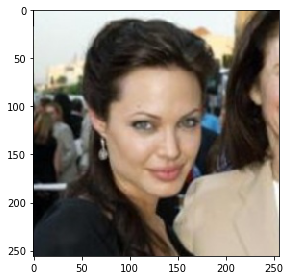

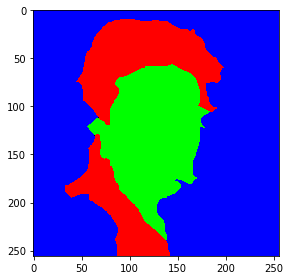

1


In [0]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(np.round(Y_train[ix]*255)))
plt.show()

print(Y_train[ix][1][1][2])

# **II. Model Definition**

**CFCN-seg**

In [0]:
# support functions for CFCN-seg
# dice coefficient metric
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

# loss function based on dice coefficient
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

# loss function combining binary crossentropy and dice loss
def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# loss function combining categorical crossentropy and dice loss
def ce_dice_loss(y_true, y_pred):
    loss = categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [0]:
# define CFCN-seg
# define input shape
inputs = Input((img_height, img_width, img_channels))
# perform feature scaling on inputs
s = Lambda(lambda x: x/255)(inputs)

# convolutional encoder blocks 
# each convolutional block is similar to the ones used in Assignment 2, but with additional batch normalization and dropout layers after each pooling layer to reduce overfittingr
c11 = Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(s)
p11 = MaxPooling2D(2,2)(c11)
l11 = BatchNormalization()(p11)
l11 = Dropout(0.5)(l11)
c12 = Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(l11)
p12 = MaxPooling2D(2,2)(c12)
l1 = BatchNormalization()(p12)
l1 = Dropout(0.5)(l1)

c21 = Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu')(l1)
p21 = MaxPooling2D(2,2)(c21)
l21 = BatchNormalization()(p21)
l21 = Dropout(0.5)(l21)
c22 = Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu')(l21)
p22 = MaxPooling2D(2,2)(c22)
l2 = BatchNormalization()(p22)
l2 = Dropout(0.5)(l2)

# additional convolutional blocks in encoder to improve model accuracy
cn1 = Conv2D(256, kernel_size=(3,3), strides=1, padding='same', activation='relu')(l2)
pn1 = MaxPooling2D(2,2)(cn1)
ln1 = BatchNormalization()(pn1)
ln1 = Dropout(0.5)(ln1)
co1 = Conv2D(256, kernel_size=(3,3), strides=1, padding='same', activation='relu')(ln1)
po1 = MaxPooling2D(2,2)(co1)
lo1 = BatchNormalization()(po1)
lo1 = Dropout(0.5)(lo1)

cp1 = Conv2D(512, kernel_size=(3,3), strides=1, padding='same', activation='relu')(lo1)
pp1 = MaxPooling2D(2,2)(cp1)
lp1 = BatchNormalization()(pp1)
lp1 = Dropout(0.5)(lp1)
cq1 = Conv2D(512, kernel_size=(3,3), strides=1, padding='same', activation='relu')(lp1)
pq1 = MaxPooling2D(2,2)(cq1)
lq1 = BatchNormalization()(pq1)
lq1 = Dropout(0.5)(lq1)

'''
c3 = Conv2D(1024, kernel_size=(3,3), strides=1, padding='same', activation='relu')(lq1)
l3 = BatchNormalization()(c3)
l3 = Dropout(0.5)(l3)
c3 = Conv2D(1024, kernel_size=(3,3), strides=1, padding='same', activation='relu')(l3)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.5)(c3)
'''

c3 = Flatten()(lq1)
c3 = Dense(3, activation='softmax')(c3)
c3 = Dropout(0.3)(c3)
c3 = Dense(1024, activation='softmax')(c3)
c3 = Reshape((1,1,1024))(c3)

# decoder blocks
# based on decoder blocks used in U-Net

# additional decoder blocks to match encoder blocks
up4 = Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c3)
up4 = concatenate([cq1, up4])
cp4 = Conv2D(512, kernel_size=(3,3), strides=1, padding='same', activation='relu')(up4)
lp4 = BatchNormalization()(cp4)
lp4 = Dropout(0.5)(lp4)
cp4 = Conv2D(512, kernel_size=(3,3), strides=1, padding='same', activation='relu')(lp4)

uq4 = Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(cp4)
uq4 = concatenate([cp1, uq4])
cq4 = Conv2D(512, kernel_size=(3,3), strides=1, padding='same', activation='relu')(uq4)
lq4 = BatchNormalization()(cq4)
lq4 = Dropout(0.5)(lq4)
cq4 = Conv2D(512, kernel_size=(3,3), strides=1, padding='same', activation='relu')(lq4)

un4 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(cq4)
un4 = concatenate([co1, un4])
cn4 = Conv2D(256, kernel_size=(3,3), strides=1, padding='same', activation='relu')(un4)
ln4 = BatchNormalization()(cn4)
ln4 = Dropout(0.5)(ln4)
cn4 = Conv2D(256, kernel_size=(3,3), strides=1, padding='same', activation='relu')(ln4)

uo4 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(cn4)
uo4 = concatenate([cn1, uo4])
co4 = Conv2D(256, kernel_size=(3,3), strides=1, padding='same', activation='relu')(uo4)
lo4 = BatchNormalization()(co4)
lo4 = Dropout(0.5)(lo4)
co4 = Conv2D(256, kernel_size=(3,3), strides=1, padding='same', activation='relu')(lo4)

u4 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(co4)
u4 = concatenate([c22, u4])
c4 = Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu')(u4)
l4 = BatchNormalization()(c4)
l4 = Dropout(0.5)(l4)
c4 = Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu')(l4)

u5 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c4)
u5 = concatenate([c21, u5])
c5 = Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu')(u5)
l5 = BatchNormalization()(c5)
l5 = Dropout(0.5)(l5)
c5 = Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu')(l5)

u6 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c5)
u6 = concatenate([c12, u6])
c6 = Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(u6)
l6 = BatchNormalization()(c6)
l6 = Dropout(0.5)(l6)
c6 = Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(l6)

u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = concatenate([c11, u7])
c7 = Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(u7)
l7 = BatchNormalization()(c7)
l7 = Dropout(0.5)(l7)
c7 = Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(l7)

# output layer
# same as U-Net
outputs = Conv2D(3, (1, 1), activation='sigmoid') (c7)

model = Model(inputs=[inputs], outputs=[outputs])
model.name = 'Troika-M'
model.summary()

# compile model with custom loss function and metric
model.compile(optimizer='adam', loss=ce_dice_loss, metrics=[dice_coeff])

Model: "CFCN-seg"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 256, 256, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_129 (Conv2D)             (None, 256, 256, 64) 1792        lambda_6[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_41 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_129[0][0]                 
___________________________________________________________________________________________

- dense layer between encoder & decoder
- gaussian noise stddev=0.1
- conv2d - batchnorm - conv2d - batchnorm

# **III. Training**

In [0]:
earlystopper = EarlyStopping(patience=100, verbose=1, monitor='val_loss', mode='max')
cp = ModelCheckpoint('A4-weights.h5', verbose=1, monitor='val_dice_coeff', mode='max', save_best_only=True)
batch = 5

In [0]:
print(model.name)
res = model.fit(X_train, Y_train, batch_size=batch, epochs=25, callbacks=[cp], validation_data=(X_valid, Y_valid))
#res = model.fit(X_train, Y_train, batch_size=batch, epochs=500, callbacks=[cp], validation_data=(X_valid, Y_valid))

CFCN-seg
Train on 1500 samples, validate on 500 samples
Epoch 1/25
1500/1500 [==============================] - 155s 104ms/step - loss: 0.5140 - dice_coeff: 0.8417 - val_loss: 0.8908 - val_dice_coeff: 0.8145

Epoch 00001: val_dice_coeff improved from -inf to 0.81450, saving model to A4-weights.h5
Epoch 2/25
1500/1500 [==============================] - 141s 94ms/step - loss: 0.4089 - dice_coeff: 0.8757 - val_loss: 0.3759 - val_dice_coeff: 0.8885

Epoch 00002: val_dice_coeff improved from 0.81450 to 0.88853, saving model to A4-weights.h5
Epoch 3/25
1500/1500 [==============================] - 141s 94ms/step - loss: 0.3697 - dice_coeff: 0.8871 - val_loss: 0.3534 - val_dice_coeff: 0.8927

Epoch 00003: val_dice_coeff improved from 0.88853 to 0.89273, saving model to A4-weights.h5
Epoch 4/25
1500/1500 [==============================] - 141s 94ms/step - loss: 0.3367 - dice_coeff: 0.8972 - val_loss: 0.3487 - val_dice_coeff: 0.9035

Epoch 00004: val_dice_coeff improved from 0.89273 to 0.90350, 

In [0]:
# reconfigure model for hair masks
model.layers.pop()
out = Conv2D(1, (1, 1), activation='sigmoid')(model.layers[len(model.layers)-1].output)
model = Model(input=model.input, output=out)
model.summary()
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coeff])

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 256, 256, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_129 (Conv2D)             (None, 256, 256, 64) 1792        lambda_6[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_41 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_129[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# set parameters for hair masks
img_height = 256
img_width = 256
img_channels = 3

# set paths to data folders
train_X_path = 'CS499A3_Data/training_images/'
valid_X_path = 'CS499A3_Data/validation_images/'

train_Y_path = 'CS499A3_Data/training_masks/'
valid_Y_path = 'CS499A3_Data/validation_masks/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
num_classes = 1

# 2 classes for hair/skin segmentation
# num_classes = 2
# use categorical crossentropy w/ dice loss as loss function

In [0]:
# get training and testing IDs of hair masks
# sort lists into same order
train_X_ids = next(os.walk(train_X_path))[2]
train_X_ids.sort()
valid_X_ids = next(os.walk(valid_X_path))[2]
valid_X_ids.sort()

train_Y_ids = next(os.walk(train_Y_path))[2]
train_Y_ids.sort()
valid_Y_ids = next(os.walk(valid_Y_path))[2]
valid_Y_ids.sort()

In [0]:
# get hair mask data and resize
# instantiate empty arrays for training images and masks
X_train = np.zeros((len(train_X_ids), img_height, img_width, img_channels), dtype=np.uint8)
Y_train = np.zeros((len(train_Y_ids), img_height, img_width, 1), dtype=np.bool)

# get and resize training images
print("Getting training images\n")
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_X_ids), total=len(train_X_ids)):
  X_path = train_X_path + id_
  img = imread(X_path)[:,:,:img_channels]
  img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
  X_train[n] = img

sys.stdout.flush()

# get and resize training masks
print("\nGetting training masks")
sys.stdout.flush()
mask = np.zeros((img_height, img_width,1), dtype=np.bool)
for n, id_ in tqdm(enumerate(train_Y_ids), total=len(train_Y_ids)):
  Y_path = train_Y_path + id_
  mask_ = imread(Y_path, as_gray=True)
  mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode='constant', preserve_range=True), axis=-1)
  # perform feature scaling
  mask_ = np.round(mask_/255)
  mask_ = resize(mask_, (img_height, img_width), mode='constant', preserve_range=True)
  mask = np.maximum(mask, mask_)
  Y_train[n] = mask_

# instantiate empty arrays for validation images and masks
X_valid = np.zeros((len(valid_X_ids), img_height, img_width, img_channels), dtype=np.uint8)
Y_valid = np.zeros((len(valid_Y_ids), img_height, img_width, 1), dtype=np.bool)

# get and resize validation images
print("\nGetting validation images")
sys.stdout.flush()
for n, id_ in tqdm(enumerate(valid_X_ids), total=len(valid_X_ids)):
  X_path = valid_X_path + id_
  img = imread(X_path)[:,:,:img_channels]
  img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
  X_valid[n] = img

# get and resize validation masks
print("\nGetting validation masks")
sys.stdout.flush()
mask = np.zeros((img_height, img_width,1), dtype=np.bool)
for n, id_ in tqdm(enumerate(valid_Y_ids), total=len(valid_Y_ids)):
  Y_path = valid_Y_path + id_
  mask_ = imread(Y_path)
  mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode='constant', preserve_range=True),axis=-1)
  # perform feature scaling
  mask_ = np.round(mask_/255)
  mask_ = resize(mask_, (img_height, img_width), mode='constant', preserve_range=True)
  mask = np.maximum(mask, mask_)
  Y_valid[n] = mask_


In [0]:
# train w/ hair mask data
print(model.name)
res = model.fit(X_train, Y_train, batch_size=batch, epochs=50, callbacks=[cp], validation_data=(X_valid, Y_valid))
#res = model.fit(X_train, Y_train, batch_size=batch, epochs=500, callbacks=[cp], validation_data=(X_valid, Y_valid))

# **IV. Prediction Processing**

In [0]:
# optional cell to load trained model
model = load_model('A4-weights.h5', custom_objects={"dice_coeff": dice_coeff, "dice_loss":dice_loss})

In [0]:
# generate predictions on validation set
preds_val = model.predict(X_valid, verbose=1)

500/500 [==============================] - 12s 24ms/step


image


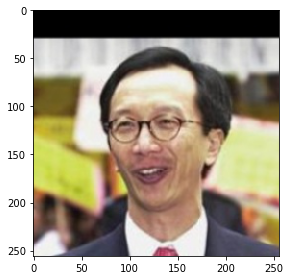

target


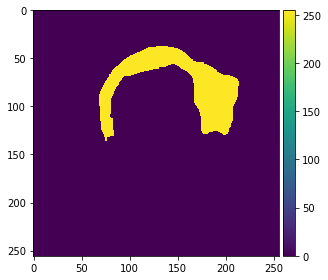

prediction


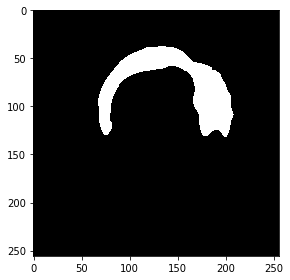

In [0]:
# perform visual comparison of predicted mask and actual mask on validation set
ix = random.randint(0, len(preds_val))
print('image')
imshow(X_valid[ix])
plt.show()
print('target')
imshow(np.squeeze(Y_valid[ix]*255))
plt.show()
print('prediction')
imshow(np.squeeze(np.round(preds_val[ix])))
plt.show()


In [0]:
# prepare testing images
test_path = 'CS499A3_Data/testing_hair_skin_images/'
# CelebA Setting
#test_path = 'CS499A3_Data/CelebA_Test/'
# generate list of test ids
test_ids = next(os.walk(test_path))[2]

# create empty array to store test masks
X_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype=np.uint8)

# get and resize training images
print("Getting testing images\n")
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
  X_path = test_path + id_
  img = imread(X_path)[:,:,:img_channels]
  img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
  X_test[n] = img

In [0]:
#generate test predictions
test_preds = model.predict(X_test, verbose=1)

927/927 [==============================] - 20s 22ms/step


In [0]:
# perform visual inspection of predicted mask on testing set
ix = random.randint(0, len(test_preds))
print(test_ids[ix])
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(np.round(test_preds[ix])))
plt.show()
#print(test_preds[ix][1][1][2])

In [0]:
# save masks
for x, z in zip(test_preds, test_ids):
  # save masks and images in temporary files, then load again to resize
  imsave("test_y.jpg", np.squeeze(np.round(x)*255).astype('uint8'))
  #imsave("test_y.jpg", np.squeeze(np.round(x)).astype('uint8'))
  img_y = imread("test_y.jpg")
  img_y = resize(img_y, (250, 250), mode='constant', preserve_range=True)
  # resize for CelebA (may result in data loss) 
  #img_y = resize(img_y, (218, 178), mode='constant', preserve_range=True)

 
  # save final mask files in new directory
  mask_id = re.split('_|\.', z)[2]
  # CelebA Setting
  #mask_id = re.split('_|\.', z)[0]
  mask_name = 'CS499A3_Data/testing_masks/test_mask_' + mask_id +'.jpg'
  imsave(mask_name, img_y.astype('uint8'))

In [0]:
# save masks in zip file
!zip -r 'test_masks.zip' /content/CS499A3_Data/testing_masks/

In [0]:
# generate sorted list of test mask ids
test_y_ids = []
for i in range(len(test_preds)):
  curr_id = 'test_mask_' + str(i+1) + '.jpg'
  test_y_ids.append(curr_id)

# **V. Export**

In [0]:
# encoding function
# based on the implementation: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python/code
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [0]:
input_path = 'CS499A3_Data/testing_masks'
masks = test_y_ids

# encode all masks
encodings = []
for file in masks:
    mask = imread(os.path.join(input_path, file))
    #img_size =10
    #mask = resize(mask, (img_size, img_size), mode='constant', preserve_range=True)
    mask = np.array(mask, dtype=np.uint8)
    mask = np.round(mask/255)
    encodings.append(rle_encoding(mask))


# (** update) the path where to save the submission csv file
sub = pd.DataFrame()
sub['ImageId'] = pd.Series(masks).apply(lambda x: os.path.splitext(x)[0])
sub['EncodedPixels'] = pd.Series(encodings).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(os.path.join('/content/', 'test_seg.csv'), index=False)